In [1]:
import numpy as np
import pandas as pd
from math import isnan
import roc_utils as roc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("hiae.csv")
hmvsc = pd.read_csv("hmvsc.csv")

## Data prep

In [3]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [1, 80],
    'highest_temperature1h': [25, 46],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [1, 200],
    'lowest_diastolic_blood_pressure1h': [1, 200],
    'lowest_systolic_blood_pressure1h': [1, 300],
    'bmi': [10, 70]
}

In [4]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [5]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [6]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [7]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [8]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [9]:
# Lists of variable types
target = "hospitalexpireflag"

demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["lowest_glasgow_coma_scale1h"]
                 
c_cols = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "lowest_glasgow_coma_scale1h", "bmi_group"]

n_cols = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h"]

In [10]:
# Group gcs
hiae['lowest_glasgow_coma_scale1h'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['lowest_glasgow_coma_scale1h'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [11]:
class CustomImputer:
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [12]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
        output.fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [13]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

## Logit trained in HIAE data

In [14]:
# Separates X and y
X_hiae = hiae[demographic+physiological+glasgow].copy()
y_hiae = hiae[target].copy()

# Separates X and y
X_hmvsc = hmvsc[demographic+physiological+glasgow].copy()
y_hmvsc = hmvsc[target].copy()

# Create null flag column
null_hiae = {}
null_hmvsc = {}
for c in X_hiae.columns:
    X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
    X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

In [15]:
# Get unique values for categorical features
values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Create pipeline
pipe = Pipeline([
    ("imputer", CustomImputer(normal, c_cols)),
    ("lenc", CustomLabelEncoder(values)),
    ("ohe", OneHotEncoder(c_cols)),
    ("scaler", DataFrameMapper([
        (n_cols, StandardScaler())
    ], default=None))
])

In [90]:
# Split StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

y_true_hiae = []
y_logr_hiae = []
for train, test in skf.split(X_hiae, y_hiae):
    # Get train and test sets
    X_train, X_test = X_hiae.loc[train], X_hiae.loc[test]
    y_train, y_test = y_hiae.loc[train], y_hiae.loc[test]

    # Run pipeline
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)
    
    # Run models
    logr = LogisticRegression()
    logr.fit(X_train, y_train)
    
    # Calibrate model
    logr = CalibratedClassifierCV(logr, cv='prefit')
    logr.fit(X_train, y_train)
    
    # Predict probs
    y_true_hiae.extend(y_test)
    y_logr_hiae.extend(logr.predict_proba(X_test))
    
# Numpy array of probs
y_logr_hiae = np.array(y_logr_hiae)[:,1]

In [91]:
np.savetxt("true", y_true_hiae)
np.savetxt("predict", y_logr_hiae)

In [95]:
# HMVSC validation
X_train, y_train = X_hiae.copy(), y_hiae.copy()
X_test, y_test = X_hmvsc.copy(), y_hmvsc.copy()

# Run pipeline
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# Run models
logr = LogisticRegression()
logr.fit(X_train, y_train)

# Predict probs
X_rec = logr.predict_proba(X_test)
X_rec = [v ** (1/3) for v in X_rec]
y_rec = y_test.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec,
                                                    test_size=y_rec.size-600, random_state=42, stratify=y_rec)

# Run models
rec = LogisticRegression(class_weight={0:1.,1:1.7})
rec.fit(X_train, y_train)
    
# Predict probs
y_true_hmvsc = np.array(y_test)
y_logr_hmvsc = rec.predict_proba(X_test)[:,1]

In [96]:
np.savetxt("true", y_true_hmvsc)
np.savetxt("predict", y_logr_hmvsc)

0.8301152766697958 AUC HIAE
0.829669068305432 AUC HMVSC


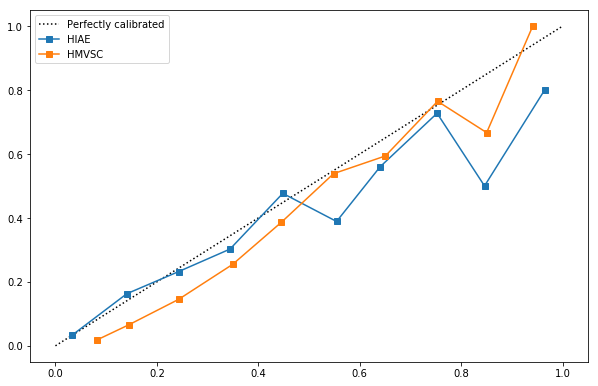

In [97]:
# Metrics Logit

# Perfectly calibrated curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Define number of bins
n_bins = 10

# HIAE metrics
print(roc_auc_score(y_true_hiae, y_logr_hiae), "AUC HIAE")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hiae, y_logr_hiae, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HIAE")


# HMVSC metrics
print(roc_auc_score(y_true_hmvsc, y_logr_hmvsc), "AUC HMVSC")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hmvsc, y_logr_hmvsc, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HMVSC")
    
# Plot calibration
plt.legend()
plt.show()

### XGBoost trained in HIAE data

In [631]:
# Separates X and y
X_hiae = hiae[demographic+physiological+glasgow].copy()
y_hiae = hiae[target].copy()

# Separates X and y
X_hmvsc = hmvsc[demographic+physiological+glasgow].copy()
y_hmvsc = hmvsc[target].copy()

In [632]:
# Get unique values for categorical features
values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

# Create pipeline
pipe = Pipeline([
#     ("imputer", CustomImputer(normal, c_cols)),
    ("lenc", CustomLabelEncoder(values))
])

In [633]:
X_hiae.head(5)

,genders,admissionsourcename,admissiontypename,chronic_health_status_name,age,lengthhospitalstaypriorunitadmission,bmi_group,lowest_systolic_blood_pressure1h,lowest_diastolic_blood_pressure1h,lowest_mean_arterial_pressure1h,highest_heart_rate1h,highest_respiratory_rate1h,highest_temperature1h,lowest_glasgow_coma_scale1h
0,1,emergency room,Clínica,Necessidade de Assistência,85,0.0,over,105.0,73.0,83.666666,78.0,20.0,36.9,2.0
1,1,operating room,Cirurgia eletiva,Independente,55,5.0,over,166.0,67.0,100.000000,60.0,15.0,35.0,1.0
2,1,emergency room,Clínica,Independente,65,0.0,NaN,118.0,50.0,72.666666,55.0,16.0,34.9,2.0
3,0,emergency room,Clínica,Independente,28,1.0,normal,114.0,59.0,77.333333,76.0,30.0,36.3,2.0
4,1,operating room,Cirurgia eletiva,Independente,70,1.0,normal,108.0,63.0,78.000000,54.0,10.0,34.0,2.0


In [469]:
X_hmvsc.head(5)

,genders,admissionsourcename,admissiontypename,chronic_health_status_name,age,lengthhospitalstaypriorunitadmission,bmi_group,lowest_systolic_blood_pressure1h,lowest_diastolic_blood_pressure1h,lowest_mean_arterial_pressure1h,highest_heart_rate1h,highest_respiratory_rate1h,highest_temperature1h,lowest_glasgow_coma_scale1h
0,1.0,floor,Clínica,Necessidade de Assistência,66.0,3.0,normal,203.0,88.0,126.333333,87.0,18.0,36.5,1.0
1,1.0,emergency room,Clínica,Independente,42.0,0.0,under,88.0,56.0,66.666666,67.0,18.0,36.1,2.0
2,1.0,emergency room,Clínica,Independente,62.0,0.0,over,66.0,34.0,44.666666,78.0,24.0,37.5,2.0
3,1.0,other sources,Clínica,Necessidade de Assistência,66.0,0.0,normal,135.0,80.0,98.333333,56.0,16.0,35.0,NaN
4,1.0,other sources,Clínica,Independente,56.0,0.0,normal,102.0,67.0,78.666666,106.0,22.0,37.0,2.0


In [480]:
# Split StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42)

y_true_hiae = []
y_xbst_hiae = []
for train, test in skf.split(X_hiae, y_hiae):
    # Get train and test sets
    X_train, X_test = X_hiae.loc[train], X_hiae.loc[test]
    y_train, y_test = y_hiae.loc[train], y_hiae.loc[test]
    
    # Run pipeline
    X_train = pipe.fit_transform(X_train)
    X_test = pipe.transform(X_test)
    
    # Run models
    xbst = XGBClassifier(n_estimators=100, max_depth=2)
    xbst.fit(X_train, y_train)
    
    # Predict probs
    y_true_hiae.extend(y_test)
    y_xbst_hiae.extend(xbst.predict_proba(X_test)[:,1])
    
# Numpy array of probs
y_xbst_hiae = np.array(y_xbst_hiae)

In [486]:
# HMVSC validation
X_train, y_train = X_hiae.copy(), y_hiae.copy()
X_test, y_test = X_hmvsc.copy(), y_hmvsc.copy()

# Run pipeline
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# Run models
xbst.fit(X_train, y_train)

# Predict probs
X_rec = xbst.predict_proba(X_test)
y_rec = y_test.copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X_rec, y_rec,
                                                    test_size=y_test.size-600, random_state=42, stratify=y_test)

# Run models
rec = LogisticRegression(class_weight={0:1.,1:2.})
rec.fit(X_train, y_train)
    
# Predict probs
y_true_hmvsc = np.array(y_test)
y_xbst_hmvsc = rec.predict_proba(X_test)[:,1]

0.8359032843142763 AUC HIAE
0.8310229332956607 AUC HMVSC


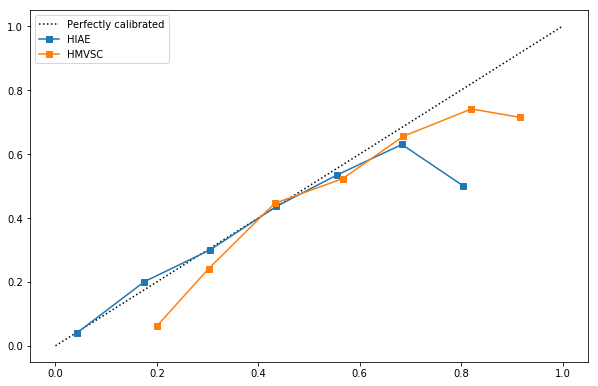

In [488]:
# Metrics XGBoost

# Perfectly calibrated curve
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Define number of bins
n_bins = 8

# HIAE metrics
print(roc_auc_score(y_true_hiae, y_xbst_hiae), "AUC HIAE")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hiae, y_xbst_hiae, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HIAE")


# HMVSC metrics
print(roc_auc_score(y_true_hmvsc, y_xbst_hmvsc), "AUC HMVSC")

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_hmvsc, y_xbst_hmvsc, n_bins=n_bins)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="HMVSC")


# Plot calibration
plt.legend()
plt.show()

In [401]:
np.savetxt("true", y_true_hmvsc)
np.savetxt("predict", y_xbst_hmvsc)